In [31]:
import numpy as np
import pandas as pd
import pickle as pkl
import xarray as xr
import copy
import os
import sys
import metrics
import random
import matplotlib as mpl
from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Tahoma']
# font = {'family' : 'sans-serif','size'   : 9}
# mpl.rc('font', **font)
# mpl.rcParams['axes.labelsize'] = 9
# mpl.rcParams['xtick.labelsize'] = 9
# mpl.rcParams['ytick.labelsize'] = 9
# mpl.rcParams['legend.fontsize'] = 7
# mpl.rcParams['lines.markersize'] = 1.5
# mpl.rcParams['lines.linewidth'] = 1.5
# mpl.rcParams["axes.titlesize"] = 8
# mpl.rcParams["grid.color"] = "#dddddd"
# mpl.rcParams["grid.linewidth"] = 0.5
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as st

In [2]:
#Utility function to create a matplotlib figure with cm sizes

def cm2inch(width: float, height: float) -> tuple:
    """Converts figure size from centimeters to inch.
    
    Parameters
    ----------
    width : float
        Width of figure in centimeters
    height : float
        Height of figure in centimeters
    
    Returns
    -------
    Tuple[float, float]
        Tuple containing width and height in inches
    """
    inch = 2.54
    return (width / inch, height / inch)

In [3]:
xr.__version__

'0.16.1'

In [4]:
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [5]:
# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [6]:
# Get the hydrologic units for each basin.
with open('../data/usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in pd_attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
pd_attributes['basin_hydro_unit'] = basin_hydro_unit
huc_regions = set(list(pd_attributes['basin_hydro_unit']))

In [7]:
basin_plot_unit = []
for b in pd_attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    if int(hu[0:2]) < 4:
        basin_plot_unit.append('east')
    elif int(hu[0:2]) < 13:
        basin_plot_unit.append('central')
    else:
        basin_plot_unit.append('west')
pd_attributes['basin_plot_unit'] = basin_plot_unit
plot_units = set(list(pd_attributes['basin_plot_unit']))

In [8]:
forcing_products = ['nldas', 'daymet']
time_splitz = ['time_split1','time_split2']
error_typez = ['absolute', 'positive', 'negative']
time_split_numbers = [1,2]

In [9]:
analysis_dict_all={forcing_type:{} for forcing_type in forcing_products}
peak_flows_dict={forcing_type:{} for forcing_type in forcing_products}
for forcing_type in forcing_products:
    for its, time_split in enumerate(time_splitz):
        #-------------------------------------------------------------------------------------------------
        frequency_analysis_dict = 'frequency_analysis_dict_{}_{}.pkl'.format(time_split, forcing_type)
        #peak_annual_flows_dict = 'peak_annual_flows_dict_{}_{}.pkl'.format(time_split, forcing_type)
        #-------------------------------------------------------------------------------------------------

        print('    opening ', frequency_analysis_dict)
        with open(frequency_analysis_dict, 'rb') as fb:
            analysis_dict_all[forcing_type][time_split] = pkl.load(fb)


    opening  frequency_analysis_dict_time_split1_nldas.pkl
    opening  frequency_analysis_dict_time_split2_nldas.pkl
    opening  frequency_analysis_dict_time_split1_daymet.pkl
    opening  frequency_analysis_dict_time_split2_daymet.pkl


In [10]:
basin_list={forcing:{} for forcing in forcing_products}
for forcing_type in forcing_products:
    for its, time_split in enumerate(time_splitz):
        basin_list[forcing_type][time_split] = list(analysis_dict_all[forcing_type][time_split].keys())

In [11]:
#-------------------------------------------------------------------------------------------------
# Set up lists to use in loops
def get_models_flows(forcing_type, time_split='time_split2'):
    if time_split == 'time_split1':
        return (['lstm', 'mc', 'sac'], ['lstm', 'mc', 'sac', 'obs'])
    if forcing_type == 'daymet':
        return (['lstm', 'mc', 'sac'], ['lstm', 'mc', 'sac', 'obs'])
    else:
        return (['lstm', 'mc', 'sac','nwm'], ['lstm', 'mc', 'sac', 'nwm', 'obs'])
                
#-------------------------------------------------------------------------------------------------

all_metrics = ['NSE','MSE','RMSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing',
               'beta-abs', 'peakQ', 'peakRI', 'peakT', 'peakQ-perc', 'peakRI-perc', 'peakT-abs']

In [12]:
analysis_dict={forcing_type:{} for forcing_type in forcing_products}

for forcing_type in forcing_products:
    for time_split in time_splitz:
        
        models, flows = get_models_flows(forcing_type, time_split)
        
        analysis_dict[forcing_type][time_split] = \
            {metric:{model:[] for model in models} for metric in all_metrics}

        for ib, basin_0str in enumerate(basin_list[forcing_type][time_split]):
            for metric in all_metrics:
                for model in models:
                    analysis_dict[forcing_type][time_split][metric][model].extend( \
                        analysis_dict_all[forcing_type][time_split][basin_0str][metric][model])
                                

In [13]:
ylimz_bar = {'NSE':[0,1], 'MSE':[0,7], 'RMSE':[0,3.5], 'KGE':[0,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.1,0.1], 'FHV':[-40,10], 'FMS':[-45,0],'FLV':[-60,60], 'Peak-Timing':[0,1],
          'beta-abs':[0,0.25], 'peakQ':[-7500, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,0.7], 'peakRI-perc':[0,1], 'peakT-abs':[0,12]}
ylimz_box = {'NSE':[0,1], 'MSE':[0,7], 'RMSE':[0,3.5], 'KGE':[0,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.1,0.1], 'FHV':[-40,10], 'FMS':[-45,0],'FLV':[-60,60], 'Peak-Timing':[0,1],
          'beta-abs':[0,0.25], 'peakQ':[-7500, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,1], 'peakRI-perc':[0,1], 'peakT-abs':[0,12]}
xlimz_freq = {'NSE':[-1,1], 'MSE':[0,1], 'RMSE':[0,0.7], 'KGE':[-1,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.4,0.1], 'FHV':[-60,60], 'FMS':[0,-60],'FLV':[-25,25], 'Peak-Timing':[-1,1],
          'beta-abs':[0,0.4], 'peakQ':[-20000, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,2], 'peakRI-perc':[0,1.3], 'peakT-abs':[0,2.2]}
namz = {'NSE':'Nash–Sutcliffe efficiency', 'MSE':'Mean squared error', 'RMSE':'Root mean squared error', 
        'KGE':'Kling-Gupta efficiency', 'Alpha-NSE':'Alpha-NSE: Flow variance', 'Pearson-r':'Pearson-r', 
         'Beta-NSE':'Beta-NSE: Volume bias', 'FHV':'FHV: Top 2 % peak flow bias', 
         'FMS':'FMS: Bias of FDC midsegment slope','FLV':'FLV: 30 % low flow bias', 
         'Peak-Timing':'Peak-Timing error','beta-abs':'Absolute volume bias', 'peakQ':'Peak flow error', 
         'peakRI':'Peak recurrence interval error', 'peakT':'Timing error of peak flow', 
         'peakQ-perc':'Abs. percent error of peak flow', 'peakRI-perc':'Abs. percent error of recurrence', 
         'peakT-abs':'Absolute timing error of peak flow'}
legend_locz = {'NSE':'upper right', 'MSE':'upper left', 'RMSE':'upper left', 
        'KGE':'upper right', 'Alpha-NSE':'lower right', 'Pearson-r':'lower right', 
         'Beta-NSE':'lower left', 'FHV':'lower left', 'FMS':'lower right','FLV':'upper right', 
         'Peak-Timing':'upper right','beta-abs':'upper right', 'peakQ':'lower left', 
         'peakRI':'lower left', 'peakT':'lower left', 
         'peakQ-perc':'upper left', 'peakRI-perc':'upper left', 'peakT-abs':'upper center'}
colz = {'NSE':2, 'MSE':1, 'RMSE':1, 'KGE':2, 'Alpha-NSE':2, 'Pearson-r':1, 
         'Beta-NSE':1, 'FHV':1, 'FMS':1,'FLV':2, 'Peak-Timing':1,
          'beta-abs':2, 'peakQ':1, 'peakRI':1, 'peakT':1, 
          'peakQ-perc':1, 'peakRI-perc':1, 'peakT-abs':1}

In [14]:
model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
model_name_list = ['lstm', 'mc', 'sac', 'nwm']
model_colors = ['b', 'orange', 'red', 'red']
model_style = ['-', '-', '-', '--']
model_name_label_dict = {model_name:model_label for model_name, model_label in \
                         zip(model_name_list,model_label_list)}

base_metrics = metrics.get_available_metrics()

In [15]:
plot_metrics = ['NSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing']
ppm = {'NSE':'NSE','KGE':'KGE','Alpha-NSE':'Alpha-NSE',
       'Pearson-r':'Pearson-r','Beta-NSE':'Beta-NSE',
       'FHV':'FHV','FMS':'FMS','FLV':'FLV','peakT-abs':'Peak-Timing'}

In [16]:
def set_box_color(bp, color, linestylez='-', linewidthz=2):
    plt.setp(bp['boxes'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['whiskers'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['caps'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['medians'], color=color, linestyle=linestylez,linewidth=linewidthz)

In [17]:
#bin_names

In [18]:
with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb:
    nwm_results = pkl.load(fb)
    
lstm_results_time_split2 = {}
mclstm_results_time_split2 = {}
sacsma_results_time_split2 = {}
with open('./model_output_for_analysis/lstm_time_split2_nldas.p', 'rb') as fb:
    lstm_results_time_split2 = pkl.load(fb)
with open('./model_output_for_analysis/mclstm_time_split2_nldas.p', 'rb') as fb:
    mclstm_results_time_split2 = pkl.load(fb)
with open('./model_output_for_analysis/sacsma_time_split2_nldas.p', 'rb') as fb:
    sacsma_results_time_split2 = pkl.load(fb)
    
lstm_results_time_split1 = {}
mclstm_results_time_split1 = {}
sacsma_results_time_split1 = {}
with open('./model_output_for_analysis/lstm_time_split1_nldas_ens.p', 'rb') as fb:
    lstm_results_time_split1 = pkl.load(fb)
with open('./model_output_for_analysis/mclstm_time_split1_nldas_ens.p', 'rb') as fb:
    mclstm_results_time_split1 = pkl.load(fb)
with open('./model_output_for_analysis/sacsma_time_split1_nldas_ens.p', 'rb') as fb:
    sacsma_results_time_split1 = pkl.load(fb)

In [19]:
labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
forcingz={'nldas':'NLDAS', 'daymet':'Daymet'}

In [20]:
# total_mass_error = {}
# total_mass = {}
# cumulative_mass_all = {}

start_date1 = pd.Timestamp('1989-10-01')
end_date1 = pd.Timestamp('1999-01-01')
start_date2 = pd.Timestamp('1996-10-01')
end_date2 = pd.Timestamp('2014-01-01')

for forcing_type in forcing_products:

    with open('total_mass_error_ens.pkl', 'rb') as fb:
        total_mass_error = pkl.load(fb)
    with open('total_mass_ens.pkl', 'rb') as fb:
        total_mass = pkl.load(fb)
    with open('cumulative_mass_all_ens.pkl', 'rb') as fb: 
        cumulative_mass_all = pkl.load(fb)


In [21]:
total_mass_error_dict = {forcing_type:{tsplt:{error_type:{} for \
                         error_type in error_typez} for \
                         tsplt in time_splitz} for \
                         forcing_type in forcing_products}

In [22]:
total_mass_error['nldas']['time_split2']['absolute'].keys()

dict_keys(['lstm', 'mc', 'sac', 'obs', 'nwm'])

In [23]:

modelz = ['lstm', 'mc', 'sac', 'nwm']

total_mass_error_dict = {forcing_type:{tsplt:{error_type:{} for \
                         error_type in error_typez} for \
                         tsplt in time_splitz} for \
                         forcing_type in forcing_products}

for forcing_type in forcing_products:
    
    for tsplt in time_splitz:
        
        for iplot, error_type in enumerate(error_typez):
            
            for model in modelz:
                
                if model == 'nwm' and tsplt == 'time_split1':
                    continue
                elif model == 'nwm' and forcing_type == 'daymet':
                    continue                    
                else:
                    print('forcing_type: ', forcing_type)
                    print("tsplt: ", tsplt)
                    print("error type: ", error_type)
                    print("model: ", model)

                    print(model)
                    print('mean, median, max, min')
                    print(np.round(np.mean(total_mass_error[forcing_type][tsplt][error_type][model]),4), 
                          np.round(np.median(total_mass_error[forcing_type][tsplt][error_type][model]),4),
                          np.round(np.max(total_mass_error[forcing_type][tsplt][error_type][model]),4),
                          np.round(np.min(total_mass_error[forcing_type][tsplt][error_type][model]),4))
                    error_means = np.round(np.mean(total_mass_error[forcing_type][tsplt][error_type][model]),4)

                    total_mass_error_dict[forcing_type][tsplt][error_type][model] = error_means
            
            
            

forcing_type:  nldas
tsplt:  time_split1
error type:  absolute
model:  lstm
lstm
mean, median, max, min
0.1336 0.1004 2.0464 0.0005
forcing_type:  nldas
tsplt:  time_split1
error type:  absolute
model:  mc
mc
mean, median, max, min
0.1295 0.0983 1.4648 1e-04
forcing_type:  nldas
tsplt:  time_split1
error type:  absolute
model:  sac
sac
mean, median, max, min
0.1344 0.0962 1.8273 0.0014
forcing_type:  nldas
tsplt:  time_split1
error type:  positive
model:  lstm
lstm
mean, median, max, min
0.0247 0.0 2.0464 0.0
forcing_type:  nldas
tsplt:  time_split1
error type:  positive
model:  mc
mc
mean, median, max, min
0.0389 0.0 1.4648 0.0
forcing_type:  nldas
tsplt:  time_split1
error type:  positive
model:  sac
sac
mean, median, max, min
0.0601 0.0 1.8273 0.0
forcing_type:  nldas
tsplt:  time_split1
error type:  negative
model:  lstm
lstm
mean, median, max, min
-0.1089 -0.0718 0.0 -0.6989
forcing_type:  nldas
tsplt:  time_split1
error type:  negative
model:  mc
mc
mean, median, max, min
-0.0906

In [24]:
error_plot_df = {forcing_type:{} for forcing_type in forcing_products}

for forcing_type in forcing_products:
    
    for tsplt in time_splitz:

        if tsplt == 'time_split1' or forcing_type == 'dayment':
            colz = {'lstm':'LSTM', 'mc':'MC-LSTM', 'sac':'SAC-SMA'}
        else:
            colz = {'lstm':'LSTM', 'mc':'MC-LSTM', 'sac':'SAC-SMA', 'nwm':'NWM*'}
        
        error_plot_df[forcing_type][tsplt] = pd.DataFrame(total_mass_error_dict[forcing_type][tsplt]).transpose()
        error_plot_df[forcing_type][tsplt] = error_plot_df[forcing_type][tsplt].rename(columns=colz)
    
    

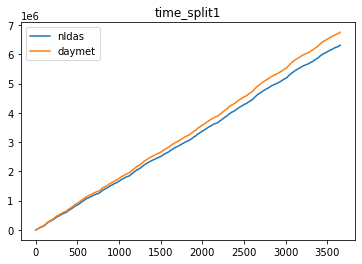

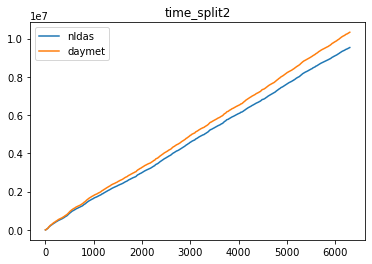

In [25]:
for tsplt in time_splitz:
    for forcing_type in forcing_products:
        plt.plot(cumulative_mass_all[forcing_type][tsplt]['precip'], label=forcing_type)
        plt.legend()
    plt.title(tsplt)
    plt.show()
    plt.close()

In [26]:
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']


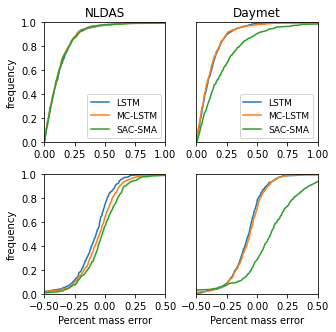

time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
['lstm', 'mc', 'sac', 'nwm']
['lstm', 'mc', 'sac', 'nwm']
['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']
['lstm', 'mc', 'sac']


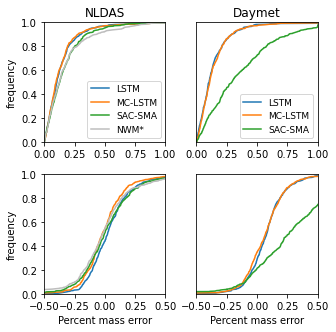

In [27]:

for tsplt in time_splitz:

    fig = plt.figure(figsize=cm2inch(12,12))
    plot_here=1

    for forcing_type in forcing_products:

        models, flows = get_models_flows(forcing_type, tsplt)
        
        print('time split', tsplt)
        print('forcing type', forcing_type)
        print('models', models)

        limz = {'absolute':([0,1],[0,1]), 'positive':([0,1],[0.4,1]), 
                'negative':([-1,0],[0,0.4]), 'neg-pos':([-.5,.5],[0,1])}
        xlabz = {'absolute':'Absolute percent mass error', 
                 'positive':'Positive mass error (percent)', 
                 'negative':'Negative mass error (percent)',
                 'neg-pos':'Percent mass error'}
        yvalues={}
        plotdata={}
        for iplot, error_type in enumerate(['absolute', 'positive', 'negative']):

            plot_dict = {model:total_mass_error[forcing_type][tsplt][error_type][model] for \
                                    model in models}
            plot_df = pd.DataFrame(plot_dict)
            print(models)
            plot_df = plot_df.loc[:,models]
            df_labz = [labelz[model] for model in plot_df.columns.values]
            plotdata[error_type] = np.sort(plot_df[~pd.isnull(plot_df)], axis=0)


        # ---------------------------------------------------------------------------------
        error_type = 'absolute'
        for model in models:
            yvalues[model] = list(range(len(total_mass_error[forcing_type][tsplt][error_type][model])))
            for i, _ in enumerate(yvalues[model]):
                yvalues[model][i] = yvalues[model][i]/len(yvalues[model])        

        if forcing_type == 'nldas':
            plot_here = 1
        elif forcing_type == 'daymet':
            plot_here = 2

        ax = fig.add_subplot(2, 2, plot_here)

        if forcing_type == 'nldas':
            ax.set_prop_cycle(color=colz)
        elif forcing_type == 'daymet':
            ax.set_prop_cycle(color=colz[:-1])

        df_plot = pd.DataFrame(data=plotdata[error_type], columns=df_labz)
        ax.plot(df_plot, yvalues[model][:len(plotdata[error_type])])
        
        ax.set_xlim(limz[error_type][0])
        ax.set_ylim(limz[error_type][1])
        ax.set_title(forcingz[forcing_type])
        ax.legend(df_labz, fontsize=9)
        if forcing_type == 'daymet':
            ax.set_yticks([])
        else:
            ax.set_ylabel("frequency")
        # ---------------------------------------------------------------------------------


        # ---------------------------------------------------------------------------------  
        error_type = 'neg-pos'
        if forcing_type == 'nldas':
            plot_here = 3
        elif forcing_type == 'daymet':
            plot_here = 4
        plotdata['neg-pos'] = np.zeros(plotdata['negative'].shape)
        iloc=0
        for j, k in zip(plotdata['negative'], plotdata['positive']):
            for a in range(plotdata['negative'].shape[1]):
                if np.abs(j[a]) > np.abs(k[a]):
                    plotdata['neg-pos'][iloc,a] = j[a]
                else:
                    plotdata['neg-pos'][iloc,a] = k[a]
            iloc+=1
        ax = fig.add_subplot(2, 2, plot_here)

        if forcing_type == 'nldas':
            ax.set_prop_cycle(color=colz)
        elif forcing_type == 'daymet':
            ax.set_prop_cycle(color=colz[:-1])

        df_plot = pd.DataFrame(data=plotdata['neg-pos'], columns=df_labz)
        ax.plot(df_plot, yvalues[model][:len(plotdata[error_type])])
        ax.set_xlim(limz[error_type][0])
        ax.set_ylim(limz[error_type][1])
        ax.set_xlabel(xlabz[error_type])
        if forcing_type == 'daymet':
            ax.set_yticks([])
        else:
            ax.set_ylabel("frequency")
        # ---------------------------------------------------------------------------------


    fig.tight_layout()
    fig.savefig('../figs/mass_error_frequencies_{}_ens.pdf'.format(tsplt), dpi=600)
    fig.savefig('../figs/mass_error_frequencies_{}_ens.png'.format(tsplt), dpi=600)
    plt.show()
    plt.close()

In [28]:
[labelz[model] for model in plot_df.columns.values]

['LSTM', 'MC-LSTM', 'SAC-SMA']

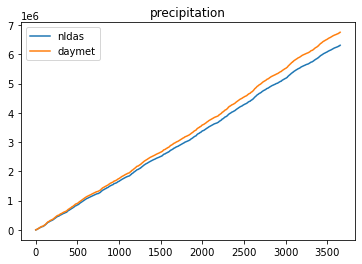

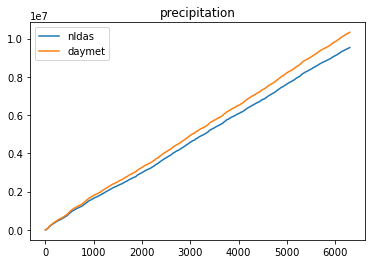

lstm


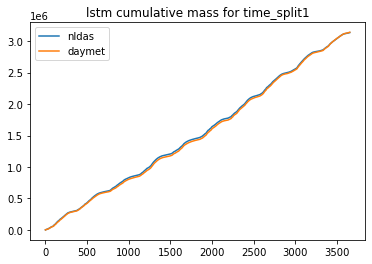

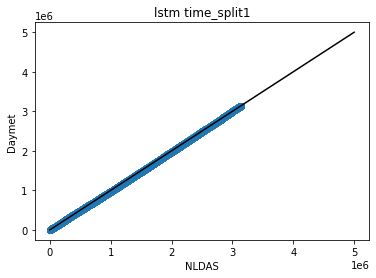

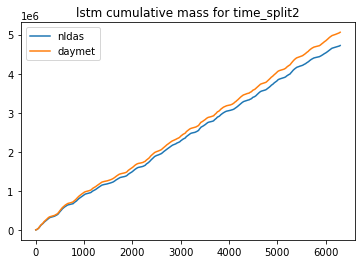

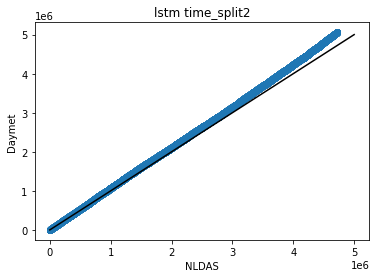

mc


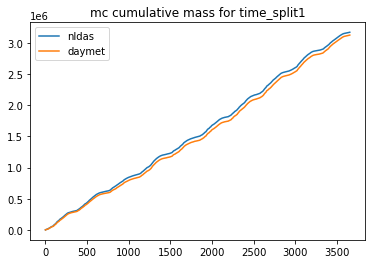

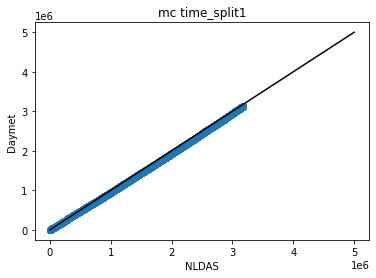

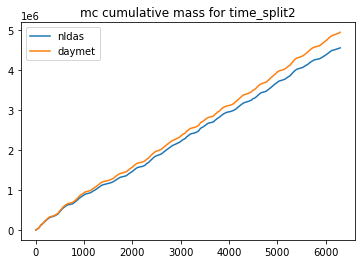

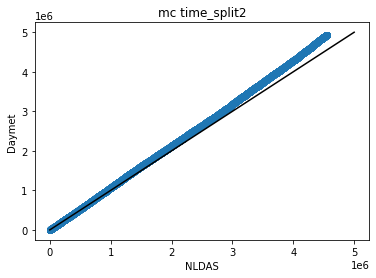

sac


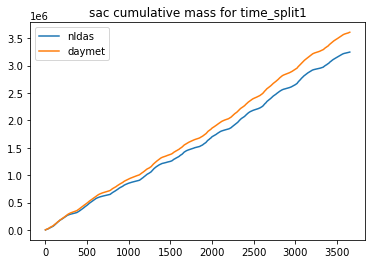

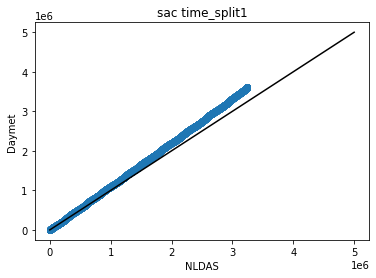

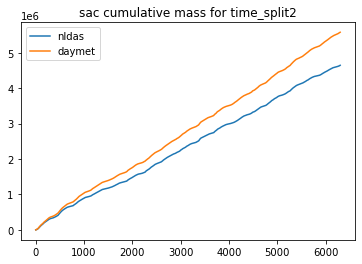

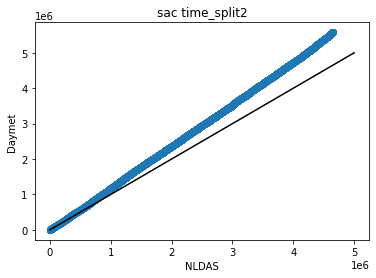

In [29]:
for tsplt in time_splitz:

    for forcing_type in forcing_products:

        models, flows = get_models_flows(forcing_type, tsplt)

        plt.plot(cumulative_mass_all[forcing_type][tsplt]['precip'], label=forcing_type)
        plt.title('precipitation')
        
    plt.legend()
    plt.show()
    plt.close()
    
    
for model in models:

    print(model)
    for tsplt in time_splitz:
    
        for forcing_type in forcing_products:

            plt.plot(cumulative_mass_all[forcing_type][tsplt][model],label=forcing_type)
        plt.title(model+" cumulative mass for "+tsplt)
        plt.legend()
        plt.show()
        plt.close()

        plt.scatter(cumulative_mass_all['nldas'][tsplt][model],
                    cumulative_mass_all['daymet'][tsplt][model])
        plt.title(model+" "+tsplt)
        plt.xlabel('NLDAS')
        plt.ylabel('Daymet')
        plt.plot([0,5e6],[0,5e6], c='k')
        plt.show()
        plt.close()

In [30]:
int(cumulative_mass_all[forcing_type][tsplt]['lstm'].shape[0]/50)-1

125

In [31]:
with open('mass_basin_list.pkl', 'rb') as fb:
    mass_basin_list = pkl.load(fb)
mass_basin_list_int = {'time_split1':[int(i) for i in mass_basin_list['time_split1']],
                       'time_split2':[int(i) for i in mass_basin_list['time_split2']]}

In [32]:
mass_error_list_for_plot={}
for tsplt in time_splitz:
    
    models, flows = get_models_flows('daymet')
    mass_error_list_for_plot[tsplt] = {forcing_type:{model:[] for model in models} for \
                                       forcing_type in forcing_products}

    if tsplt == 'time_split2':
        mass_error_list_for_plot[tsplt]['nldas']['nwm']=[]
    
    for forcing_type in forcing_products:
    
        models, flows = get_models_flows(forcing_type, tsplt)
        
        print('time split', tsplt)
        print('forcing type', forcing_type)
        print('models', models)
        
        for imod, model in enumerate(models):

            count_loop = 0

            for i, j in zip(total_mass_error[forcing_type][tsplt]['positive'][model], 
                            total_mass_error[forcing_type][tsplt]['negative'][model]):
                if forcing_type == 'Daymet' and model == 'nwm':
                    continue
                elif np.abs(i) > np.abs(j):
                    mass_error_list_for_plot[tsplt][forcing_type][model].append(i)
                elif np.abs(i) < np.abs(j):
                    mass_error_list_for_plot[tsplt][forcing_type][model].append(j)
                else:
                    print('same?')
                count_loop += 1
            print(count_loop)

time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
530
530
530
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
530
530
530
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
484
484
484
484
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
484
484
484


time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']


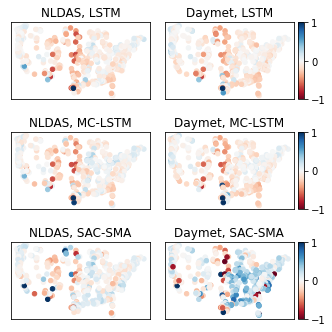

time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']


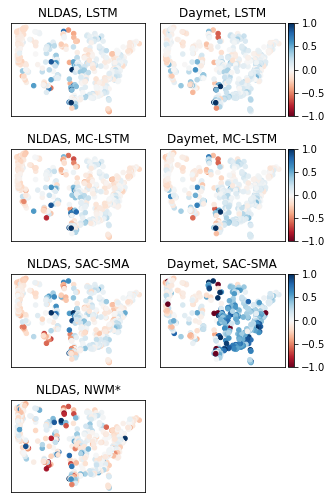

In [33]:

for tsplt in time_splitz:

    if tsplt == 'time_split1':
        fig = plt.figure(figsize=cm2inch(12,12))
    if tsplt == 'time_split2':
        fig = plt.figure(figsize=cm2inch(12,18))
    plot_here=1

    for forcing_type in forcing_products:

        models, flows = get_models_flows(forcing_type, tsplt)

        for model in models:
            
            print('time split', tsplt)
            print('forcing type', forcing_type)
            print('models', models)

            if forcing_type == 'daymet' and model == 'nwm':
                continue

            if forcing_type == 'nldas' and model == 'lstm':
                plot_here = 1
            if forcing_type == 'daymet' and model == 'lstm':
                plot_here = 2
            if forcing_type == 'nldas' and model == 'mc':
                plot_here = 3
            if forcing_type == 'daymet' and model == 'mc':
                plot_here = 4
            if forcing_type == 'nldas' and model == 'sac':
                plot_here = 5
            if forcing_type == 'daymet' and model == 'sac':
                plot_here = 6

            if tsplt == 'time_split2':
                if forcing_type == 'nldas' and model == 'nwm':
                    plot_here = 7
                    
            if tsplt == 'time_split2':
                ax = fig.add_subplot(4, 2, plot_here)
            if tsplt == 'time_split1':
                ax = fig.add_subplot(3, 2, plot_here)
                
            im = ax.scatter(pd_attributes.loc[mass_basin_list_int[tsplt], 'gauge_lon'].values, 
                             pd_attributes.loc[mass_basin_list_int[tsplt], 'gauge_lat'].values,
                            c=mass_error_list_for_plot[tsplt][forcing_type][model],
                            s=20,
                            cmap='RdBu',
                            vmin=-1, 
                            vmax=1)
            ax.set_title(str(forcingz[forcing_type])+', '+str(labelz[model]))

    #        ax.set_xlabels([])
            ax.set_xticks(ticks=[])
            ax.set_yticks(ticks=[])

            clims = im.get_clim()


            # colorbar
            if plot_here in [2,4,6]:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im, cax=cax, orientation='vertical')

            plot_here+=1

    plt.tight_layout()
    plt.show()
    fig.savefig('../figs/mass_bias_mapzz_{}_ens.pdf'.format(tsplt), dpi=600)
    fig.savefig('../figs/mass_bias_mapzz_{}_ens.png'.format(tsplt), dpi=600)
    plt.close()

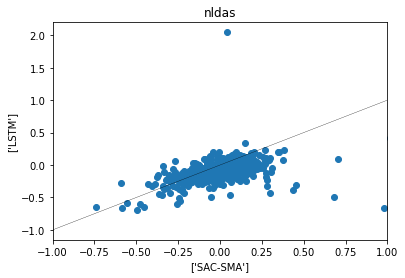

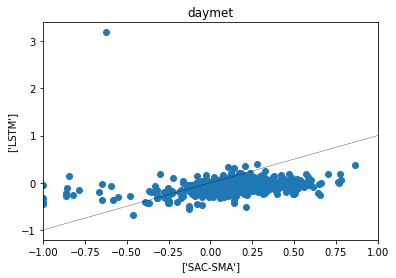

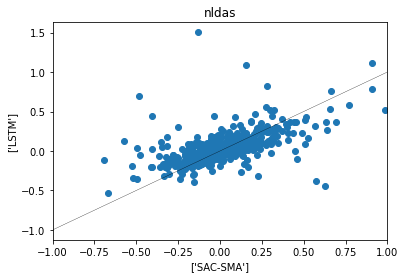

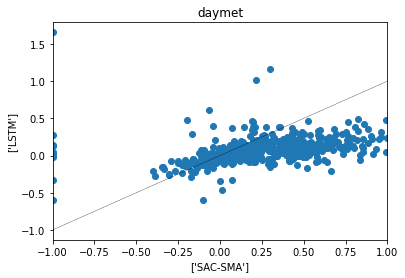

In [34]:

for tsplt in time_splitz:

    ###################################################################################
    plot_lim = 1

    plt.scatter(mass_error_list_for_plot[tsplt]['nldas']['sac'], 
                mass_error_list_for_plot[tsplt]['nldas']['lstm'])
    plt.xlabel(['SAC-SMA'])
    plt.ylabel(['LSTM'])
    plt.title('nldas')
    plt.xlim([-plot_lim,plot_lim])
    plt.plot([-plot_lim,plot_lim],[-plot_lim,plot_lim], c='k', lw=0.3)
    plt.show()
    plt.close()

    plt.scatter(mass_error_list_for_plot[tsplt]['daymet']['sac'], 
                mass_error_list_for_plot[tsplt]['daymet']['lstm'])
    plt.xlabel(['SAC-SMA'])
    plt.ylabel(['LSTM'])
    plt.title('daymet')
    plt.xlim([-plot_lim,plot_lim])
    plt.plot([-plot_lim,plot_lim],[-plot_lim,plot_lim], c='k', lw=0.3)
    plt.show()
    plt.close()

In [35]:
#basin_list_int = [np.int(mass_basin_list[i]) for i in range(len(mass_basin_list))]
mass_basin_list_int.keys()

dict_keys(['time_split1', 'time_split2'])

In [36]:
len(mass_basin_list_int['time_split2'])

484

In [37]:
mass_error_types = ['positive', 'negative', 'absolute']

In [38]:
usgs_wrregions_list = ['N.E.','Mid-Atl.','S. Atl.-Gulf','Grt. Lakes','Ohio',
                      'Tennessee','Up. Miss.','Low. Miss.','Souris-Rd',
                      'Missouri','Ark-Wt-Rd','TX-Gulf','Rio Grnd.','Upper Col.',
                      'Lower Col.','Grt. Basin','Pac. NW','California']
usgs_wrregions_lookup = {str(x+1).zfill(2):usgs_wrregions_list[x] for x in range(len(usgs_wrregions_list))}

# Not enout data to get statistics
usgs_wrregions_list.remove('Souris-Rd')

plot_regions = ['west', 'central', 'east']

TIME SPLIT:  time_split1


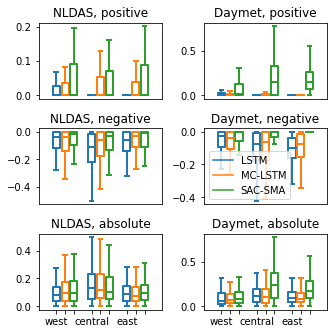

TIME SPLIT:  time_split2


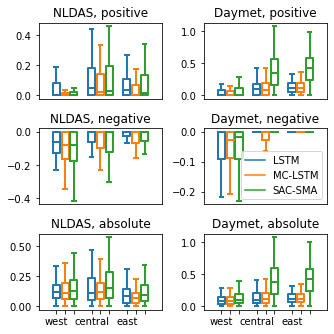

In [39]:
for tsplt in time_splitz:
    print('TIME SPLIT: ', tsplt)

    mass_bias_error_regional = {error_type:{forcing:pd.DataFrame(index=plot_regions, columns=models,
        data=np.zeros([len(plot_regions),len(models)])) for \
        forcing in forcing_products} for error_type in mass_error_types}

    mass_bias_error_dict = {error_type:{forcing:{model:{plot_region:[] for \
                                      plot_region in plot_regions} for \
                                      model in models} for \
                                      forcing in forcing_products} for \
                                      error_type in mass_error_types}


    for ib, basin in enumerate(mass_basin_list[tsplt]):
        plot_region = pd_attributes.loc[int(basin), 'basin_plot_unit']
        for forcing in forcing_products:
            for model in models:
                for error_type in mass_error_types:
                    mass_bias_error_regional[error_type][forcing].loc[plot_region, model] += \
                        total_mass_error[forcing][tsplt][error_type][model][ib]

                    mass_bias_error_dict[error_type][forcing][model][plot_region].append( \
                                total_mass_error[forcing][tsplt][error_type][model][ib])



    fig = plt.figure(figsize=cm2inch(12,12))
    plot_here=1

    blanklab = ['' for x in plot_regions]
    width=.2
    gap=0.05

    for ierr, error_type in enumerate(mass_error_types):

        for iforc, forcing in enumerate(forcing_products):

            df = mass_bias_error_regional[error_type][forcing]
            x = np.arange(len(list(df.index.values)))

            plot_loc=1 + iforc + (ierr * 2) 
            ax = fig.add_subplot(3, 2, plot_loc)

            ax.set_title(forcingz[forcing]+", "+error_type)

    #        ax.set_xlabel('U.S. region')

            data_to_plot = [mass_bias_error_dict[error_type][forcing]['lstm'][plot_region] for \
                                      plot_region in plot_regions]
            bp_lstm = ax.boxplot(data_to_plot, positions=x - width - gap, sym='', 
                                 widths=width, labels=plot_regions)

            data_to_plot = [mass_bias_error_dict[error_type][forcing]['mc'][plot_region] for \
                                      plot_region in plot_regions]
            bp_mc = ax.boxplot(data_to_plot, positions=x, sym='', 
                               widths=width, labels=blanklab)            

            data_to_plot = [mass_bias_error_dict[error_type][forcing]['sac'][plot_region] for \
                                      plot_region in plot_regions]
            bp_sac = ax.boxplot(data_to_plot, positions=x + width + gap, sym='', 
                                widths=width, labels=blanklab)

            set_box_color(bp_lstm, '#1f77b4') # colors are from http://colorbrewer2.org/
            set_box_color(bp_mc, '#ff7f0e')
            set_box_color(bp_sac, '#2ca02c') # colors are from http://colorbrewer2.org/

            if ierr in [2,5]:
                plt.xticks(rotation=0)
            else:
                plt.xticks([])

            if plot_loc == 4:
                # draw temporary red and blue lines and use them to create a legend
                plt.plot([], c='#1f77b4', label='LSTM')
                plt.plot([], c='#ff7f0e', label='MC-LSTM')
                plt.plot([], c='#2ca02c', label='SAC-SMA')
                plt.legend()

    plt.tight_layout()

    fig.tight_layout(pad=1.0)
    plt.show()
    # fig.savefig('../figs/massboxxs.pdf', dpi=600)
    # fig.savefig('../figs/massboxxs.png', dpi=600)
    plt.close()

In [40]:
usgs_wrregions_list

['N.E.',
 'Mid-Atl.',
 'S. Atl.-Gulf',
 'Grt. Lakes',
 'Ohio',
 'Tennessee',
 'Up. Miss.',
 'Low. Miss.',
 'Missouri',
 'Ark-Wt-Rd',
 'TX-Gulf',
 'Rio Grnd.',
 'Upper Col.',
 'Lower Col.',
 'Grt. Basin',
 'Pac. NW',
 'California']

In [41]:
usgs_wrregions_list_without_Souris = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18]

absolute
time split time_split1
forcing type nldas
['lstm', 'mc', 'sac']


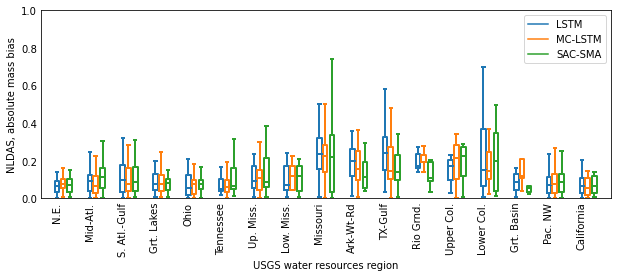

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.066945  0.080534  0.072458
1   0.093822  0.077681  0.116192
2   0.113058  0.105155  0.113154
3   0.090024  0.089017  0.085726
4   0.072773  0.080584  0.081980
5   0.081381  0.075053  0.104166
6   0.121498  0.135157  0.137645
7   0.105925  0.116224  0.108444
8   0.256266  0.244757  0.246342
9   0.200663  0.184325  0.140580
10  0.300820  0.246130  0.169084
11  0.196538  0.207824  0.131806
12  0.170510  0.210862  0.195058
13  0.231825  0.233437  0.292080
14  0.085656  0.183829  0.111272
15  0.078932  0.089157  0.096375
16  0.095174  0.082809  0.166269
lstm    0.138930
mc      0.143678
sac     0.139331
dtype: float64
absolute
time split time_split1
forcing type daymet
['lstm', 'mc', 'sac']


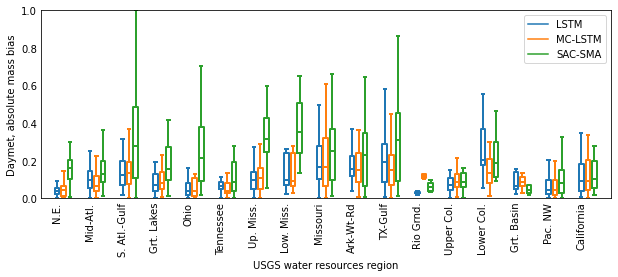

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.041800  0.048419  0.149552
1   0.106002  0.082688  0.156757
2   0.141660  0.141559  0.327103
3   0.089719  0.096387  0.177720
4   0.055103  0.062293  0.241006
5   0.076943  0.058983  0.146213
6   0.102852  0.111041  0.336553
7   0.142582  0.144076  0.374979
8   0.201779  0.201193  0.349497
9   0.178135  0.180126  0.237553
10  0.292858  0.297039  0.319011
11  0.033039  0.119830  0.119121
12  0.100180  0.127372  0.101670
13  0.282180  0.204817  0.237358
14  0.088579  0.085579  0.088960
15  0.068759  0.068273  0.117843
16  0.115194  0.123184  0.170216
lstm    0.124551
mc      0.126639
sac     0.214771
dtype: float64
absolute
time split time_split2
forcing type nldas
['lstm', 'mc', 'sac', 'nwm']


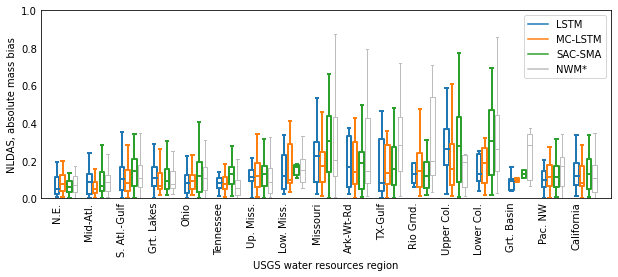

['lstm', 'mc', 'sac', 'nwm']
        lstm        mc       sac       nwm
0   0.068763  0.089123  0.061489  0.094590
1   0.084625  0.063811  0.096002  0.105660
2   0.114173  0.098214  0.149286  0.135666
3   0.124826  0.104893  0.129479  0.120205
4   0.081741  0.103354  0.122955  0.110186
5   0.079786  0.080780  0.135741  0.064509
6   0.120602  0.135369  0.128055  0.112387
7   0.147661  0.182745  0.182206  0.162747
8   0.223627  0.192813  0.319121  0.301488
9   0.241510  0.208868  0.223384  0.262601
10  0.242939  0.249101  0.197460  0.669066
11  0.166231  0.176509  0.135162  0.324148
12  0.301503  0.204969  0.328661  0.243883
13  0.222798  0.245839  0.320577  0.340464
14  0.089631  0.134115  0.125222  0.232075
15  0.100621  0.124054  0.125193  0.176688
16  0.148132  0.137427  0.162433  0.165869
lstm    0.150539
mc      0.148940
sac     0.173084
nwm     0.213072
dtype: float64
absolute
time split time_split2
forcing type daymet
['lstm', 'mc', 'sac']


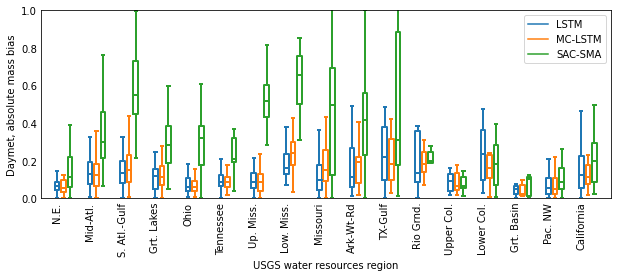

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.063827  0.063335  0.143521
1   0.139957  0.127825  0.345148
2   0.144659  0.159635  0.597048
3   0.119546  0.121754  0.301379
4   0.072159  0.070185  0.288967
5   0.100803  0.098333  0.242862
6   0.107063  0.109751  0.522918
7   0.189519  0.236723  0.619779
8   0.134461  0.186276  0.492961
9   0.181260  0.220875  0.442683
10  0.350241  0.261948  0.482409
11  0.202836  0.190804  0.193228
12  0.142744  0.151138  0.106442
13  0.233685  0.222699  0.184160
14  0.042959  0.043851  0.069596
15  0.070877  0.074803  0.136215
16  0.154069  0.148265  0.219270
lstm    0.144157
mc      0.146365
sac     0.316976
dtype: float64
positive
time split time_split1
forcing type nldas
['lstm', 'mc', 'sac']


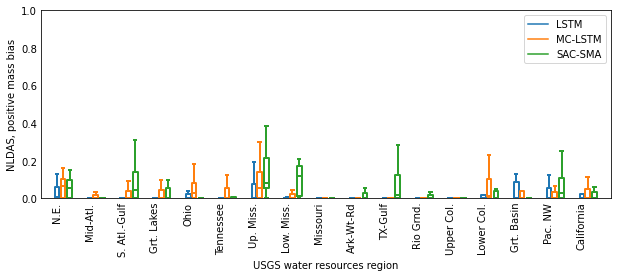

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.036840  0.062326  0.056851
1   0.008402  0.019684  0.014848
2   0.013354  0.026908  0.078794
3   0.019902  0.035141  0.031910
4   0.029401  0.057936  0.015514
5   0.008386  0.024333  0.022111
6   0.055179  0.102860  0.128351
7   0.010511  0.024491  0.099782
8   0.002460  0.013752  0.087003
9   0.012837  0.023428  0.031286
10  0.083519  0.109216  0.067286
11  0.000000  0.000000  0.033064
12  0.001944  0.003493  0.007854
13  0.042123  0.077245  0.155894
14  0.042805  0.028982  0.075641
15  0.029721  0.029286  0.058902
16  0.046028  0.041628  0.099169
lstm    0.026083
mc      0.040042
sac     0.062604
dtype: float64
positive
time split time_split1
forcing type daymet
['lstm', 'mc', 'sac']


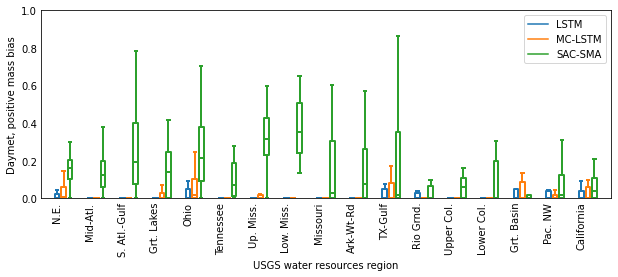

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.015323  0.034114  0.143261
1   0.009394  0.015221  0.132169
2   0.001688  0.002691  0.259412
3   0.011472  0.026624  0.133231
4   0.029839  0.050216  0.238048
5   0.005699  0.003061  0.134425
6   0.012236  0.023434  0.327180
7   0.009021  0.000000  0.374979
8   0.011623  0.004705  0.207197
9   0.019353  0.016748  0.157091
10  0.160910  0.191849  0.196440
11  0.013766  0.000000  0.090368
12  0.006799  0.012472  0.061347
13  0.028308  0.018525  0.122323
14  0.042065  0.043396  0.061392
15  0.038290  0.029723  0.081256
16  0.048481  0.052607  0.097404
lstm    0.027310
mc      0.030905
sac     0.165737
dtype: float64
positive
time split time_split2
forcing type nldas
['lstm', 'mc', 'sac', 'nwm']


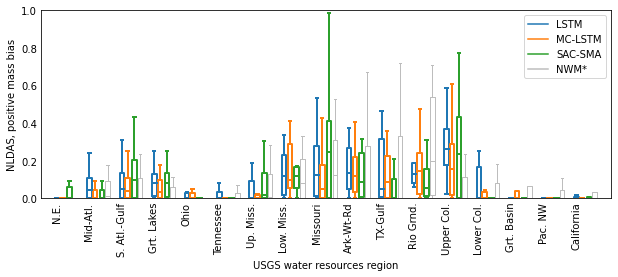

['lstm', 'mc', 'sac', 'nwm']
        lstm        mc       sac       nwm
0   0.002021  0.002886  0.022707  0.003911
1   0.066972  0.029576  0.040497  0.067525
2   0.080555  0.067123  0.117981  0.073054
3   0.097440  0.061412  0.102377  0.042858
4   0.029995  0.019138  0.021321  0.008655
5   0.021684  0.004125  0.001374  0.018664
6   0.042845  0.028024  0.076684  0.074899
7   0.136631  0.170444  0.138132  0.119803
8   0.175448  0.113608  0.255233  0.191305
9   0.213323  0.184916  0.172302  0.180051
10  0.224445  0.213053  0.096253  0.514370
11  0.166231  0.163884  0.100410  0.288077
12  0.301503  0.189633  0.305570  0.102168
13  0.135278  0.091957  0.022432  0.075500
14  0.000000  0.029076  0.026329  0.069136
15  0.016788  0.008866  0.023985  0.064869
16  0.047950  0.036171  0.032729  0.071984
lstm    0.103477
mc      0.083170
sac     0.091548
nwm     0.115696
dtype: float64
positive
time split time_split2
forcing type daymet
['lstm', 'mc', 'sac']


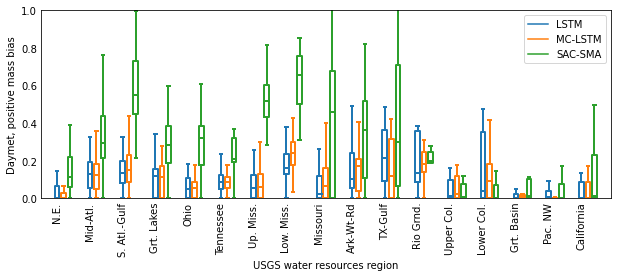

['lstm', 'mc', 'sac']
        lstm        mc       sac
0   0.034426  0.021977  0.143460
1   0.131587  0.119923  0.326630
2   0.142820  0.157576  0.597048
3   0.107517  0.104121  0.295330
4   0.060505  0.056342  0.288967
5   0.095590  0.093379  0.240382
6   0.083658  0.090224  0.522918
7   0.179702  0.236723  0.619779
8   0.078323  0.112696  0.422235
9   0.167350  0.188728  0.374348
10  0.327019  0.213236  0.413717
11  0.202836  0.180845  0.192450
12  0.103443  0.118194  0.068919
13  0.160320  0.145949  0.056661
14  0.014605  0.010937  0.045013
15  0.034369  0.014570  0.051039
16  0.077218  0.082782  0.135061
lstm    0.117723
mc      0.114600
sac     0.281998
dtype: float64
negative
time split time_split1
forcing type nldas
['lstm', 'mc', 'sac']


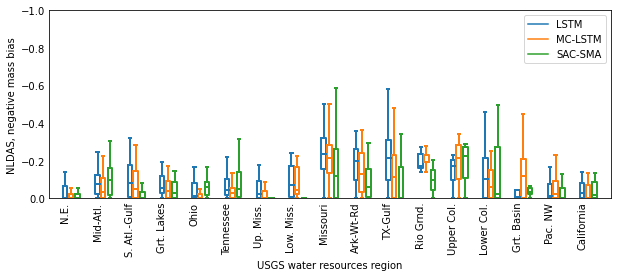

['lstm', 'mc', 'sac']
        lstm        mc       sac
0  -0.030105 -0.018208 -0.015607
1  -0.085420 -0.057997 -0.101344
2  -0.099704 -0.078246 -0.034360
3  -0.070122 -0.053876 -0.053816
4  -0.043372 -0.022648 -0.066466
5  -0.072996 -0.050719 -0.082055
6  -0.066320 -0.032296 -0.009294
7  -0.095414 -0.091733 -0.008662
8  -0.253806 -0.231005 -0.159339
9  -0.187826 -0.160897 -0.109294
10 -0.217302 -0.136914 -0.101798
11 -0.196538 -0.207824 -0.098742
12 -0.168566 -0.207369 -0.187204
13 -0.189702 -0.156192 -0.136186
14 -0.042850 -0.154847 -0.035631
15 -0.049211 -0.059871 -0.037473
16 -0.049145 -0.041181 -0.067100
lstm   -0.112847
mc     -0.103637
sac    -0.076728
dtype: float64
negative
time split time_split1
forcing type daymet
['lstm', 'mc', 'sac']


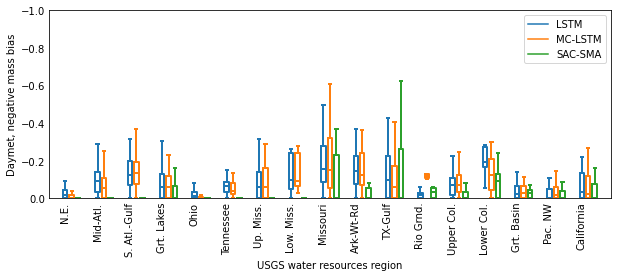

['lstm', 'mc', 'sac']
        lstm        mc       sac
0  -0.026477 -0.014305 -0.006291
1  -0.096608 -0.067468 -0.024589
2  -0.139972 -0.138868 -0.067691
3  -0.078247 -0.069763 -0.044490
4  -0.025263 -0.012077 -0.002958
5  -0.071244 -0.055923 -0.011788
6  -0.090616 -0.087607 -0.009373
7  -0.133561 -0.144076  0.000000
8  -0.190155 -0.196488 -0.142301
9  -0.158782 -0.163378 -0.080462
10 -0.131948 -0.105190 -0.122571
11 -0.019272 -0.119830 -0.028753
12 -0.093381 -0.114900 -0.040323
13 -0.253872 -0.186292 -0.115035
14 -0.046515 -0.042183 -0.027568
15 -0.030470 -0.038551 -0.036587
16 -0.066713 -0.070577 -0.072812
lstm   -0.097241
mc     -0.095734
sac    -0.049035
dtype: float64
negative
time split time_split2
forcing type nldas
['lstm', 'mc', 'sac', 'nwm']


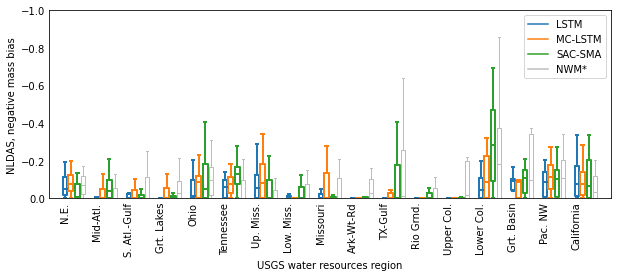

['lstm', 'mc', 'sac', 'nwm']
        lstm        mc       sac       nwm
0  -0.066742 -0.086237 -0.038782 -0.090680
1  -0.017653 -0.034235 -0.055505 -0.038135
2  -0.033618 -0.031092 -0.031305 -0.062612
3  -0.027386 -0.043481 -0.027102 -0.077347
4  -0.051746 -0.084216 -0.101634 -0.101531
5  -0.058101 -0.076655 -0.134367 -0.045845
6  -0.077757 -0.107345 -0.051370 -0.037488
7  -0.011030 -0.012300 -0.044074 -0.042945
8  -0.048179 -0.079204 -0.063887 -0.110183
9  -0.028187 -0.023952 -0.051082 -0.082550
10 -0.018495 -0.036048 -0.101207 -0.154697
11  0.000000 -0.012625 -0.034752 -0.036071
12  0.000000 -0.015336 -0.023090 -0.141715
13 -0.087520 -0.153882 -0.298145 -0.264964
14 -0.089631 -0.105039 -0.098892 -0.162938
15 -0.083833 -0.115187 -0.101208 -0.111819
16 -0.100182 -0.101256 -0.129705 -0.093885
lstm   -0.047062
mc     -0.065770
sac    -0.081536
nwm    -0.097377
dtype: float64
negative
time split time_split2
forcing type daymet
['lstm', 'mc', 'sac']


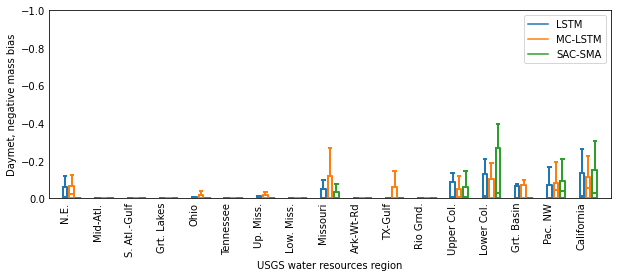

['lstm', 'mc', 'sac']
        lstm        mc       sac
0  -0.029401 -0.041358 -0.000061
1  -0.008370 -0.007901 -0.018519
2  -0.001840 -0.002059  0.000000
3  -0.012029 -0.017633 -0.006049
4  -0.011654 -0.013843  0.000000
5  -0.005213 -0.004953 -0.002480
6  -0.023405 -0.019527  0.000000
7  -0.009817  0.000000  0.000000
8  -0.056138 -0.073580 -0.070727
9  -0.013910 -0.032146 -0.068335
10 -0.023222 -0.048712 -0.068693
11  0.000000 -0.009959 -0.000778
12 -0.039300 -0.032944 -0.037523
13 -0.073365 -0.076750 -0.127499
14 -0.028354 -0.032914 -0.024583
15 -0.036508 -0.060233 -0.085176
16 -0.076851 -0.065483 -0.084209
lstm   -0.026434
mc     -0.031764
sac    -0.034978
dtype: float64


In [42]:
plot_limz = {'absolute':[0,1], 'positive':[0,1], 'negative':[0,-1]}
for error_type in ['absolute', 'positive', 'negative']:#, 'positive', 'negative']:
            
    for tsplt in time_splitz:

        for forcing in forcing_products:
        
            print(error_type)
            print('time split', tsplt)
            print('forcing type', forcing)

            models, flows = get_models_flows(forcing, tsplt)
            print(models)

            mass_bias_error_regional = {err_type:{forcing:pd.DataFrame(index=huc_regions, columns=models,
                data=np.zeros([len(huc_regions),len(models)])) for \
                forcing in forcing_products} for err_type in mass_error_types}

            mass_bias_error_dict = {err_type:{forcing:{model:{str(x).zfill(2):[] for \
                                              x in usgs_wrregions_list_without_Souris} for \
                                              model in models} for \
                                              forcing in forcing_products} for \
                                              err_type in mass_error_types}
            
            for ib, basin in enumerate(mass_basin_list[tsplt]):
                huc_id = pd_attributes.loc[int(basin), 'basin_hydro_unit']
                if huc_id == '09':
                    continue

                for model in models:

                    mass_bias_error_regional[error_type][forcing].loc[huc_id, model] += \
                        total_mass_error[forcing][tsplt][error_type][model][ib]

                    mass_bias_error_dict[error_type][forcing][model][huc_id].append(\
                        total_mass_error[forcing][tsplt][error_type][model][ib])
                    blanklab = ['' for x in usgs_wrregions_list]

                        
            width=0.14
            gapwidth=0.06

            df = mass_bias_error_regional[error_type][forcing].sort_index()
            df = df.rename(usgs_wrregions_lookup)

            fig = plt.figure(figsize=cm2inch(22,10))
            plt.ylabel(forcingz[forcing]+", "+error_type+" mass bias")
            plt.xlabel('USGS water resources region')

            x = np.arange(len(list(df.index.values))-1)
            if forcing == 'daymet':
                shift = [-(width+gapwidth), 0, (width+gapwidth)]
            elif forcing == 'nldas':
                shift = [-2*(width), -(3*width/4), (3*width/4), 2*(width)]

            data_to_plot={}
            bp={}
            data_to_plot['lstm'] = [mass_bias_error_dict[error_type][forcing]['lstm'][str(x).zfill(2)] for \
                                      x in usgs_wrregions_list_without_Souris]
            bp['lstm'] = plt.boxplot(data_to_plot['lstm'], positions=x + shift[0], 
                                sym='', widths=width, labels=usgs_wrregions_list)

            data_to_plot['mc'] = [mass_bias_error_dict[error_type][forcing]['mc'][str(x).zfill(2)] for \
                                      x in usgs_wrregions_list_without_Souris]
            bp['mc'] = plt.boxplot(data_to_plot['mc'], positions=x + shift[1] , sym='', widths=width, labels=blanklab)

            data_to_plot['sac'] = [mass_bias_error_dict[error_type][forcing]['sac'][str(x).zfill(2)] for \
                                      x in usgs_wrregions_list_without_Souris]
            bp['sac'] = plt.boxplot(data_to_plot['sac'], positions=x + shift[2], sym='', widths=width, labels=blanklab)

            set_box_color(bp['lstm'], '#1f77b4') # colors are from http://colorbrewer2.org/
            set_box_color(bp['mc'], '#ff7f0e')
            set_box_color(bp['sac'], '#2ca02c') # colors are from http://colorbrewer2.org/

            # draw temporary red and blue lines and use them to create a legend
            plt.plot([], c='#1f77b4', label='LSTM')
            plt.plot([], c='#ff7f0e', label='MC-LSTM')
            plt.plot([], c='#2ca02c', label='SAC-SMA')

            if forcing == 'nldas' and tsplt == 'time_split2':
                data_to_plot['nwm'] = [mass_bias_error_dict[error_type][forcing]['nwm'][str(x).zfill(2)] for \
                                          x in usgs_wrregions_list_without_Souris]
                bp['nwm'] = plt.boxplot(data_to_plot['nwm'], positions=x + shift[3], sym='', 
                                         widths=width, labels=blanklab)
                set_box_color(bp['nwm'], '#bdbdbd', linewidthz=1)
                plt.plot([], c='#bdbdbd', label='NWM*')

            plt.legend()

            plt.xticks(rotation=90)
            plt.tick_params(axis ='both', which ='both', length = 0)
            plt.ylim(plot_limz[error_type])
            plt.tight_layout()

            fig.tight_layout(pad=1.0)
            plt.show()
            fig.savefig('../figs/massboxxs_{}_{}_{}_ens.pdf'.format(forcing, tsplt, error_type), dpi=600)
            fig.savefig('../figs/massboxxs_{}_{}_{}_ens.png'.format(forcing, tsplt, error_type), dpi=600)
            plt.close()

    
            print(models)
            df_meanz = pd.DataFrame({model:[np.mean(data_to_plot[model][i]) for i in range(17)] for model in models})
            print(df_meanz)
            print(df_meanz.mean())
            
            

In [23]:
with open('statistics_table_st1.pkl', 'rb') as fb:
    st1_dict = pkl.load(fb)
with open('statistics_table_st2.pkl', 'rb') as fb:
    st2_dict = pkl.load(fb)

In [24]:
with open("531_basin_list.txt", "r") as f:
    basin_list_531 = pd.read_csv(f, header=None)
#basin_list_531_str = [str(basin_list_531.iloc[i]).split()[0] for i in range(basin_list_531.shape[0])]
basin_list_531_int = [basin_list_531.iloc[i].values[0] for i in range(basin_list_531.shape[0])]

metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.36


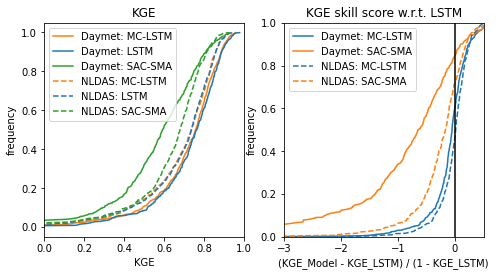

In [45]:
fig = plt.figure(figsize=cm2inch(20,10))

print("metric", "KGE")
metric_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
for forcing_type in ['daymet','nldas']:
    print("forcing_type", forcing_type)
    _, wilcoxon_p = st.wilcoxon(st1_dict[forcing_type]["KGE"]["mc"],
                                 st1_dict[forcing_type]["KGE"]["lstm"])
    print("wilcoxon p value", np.round(wilcoxon_p,2))
    metric_dict["mc"] = st1_dict[forcing_type]["KGE"]["mc"]
    metric_dict["lstm"] = st1_dict[forcing_type]["KGE"]["lstm"]

ax = fig.add_subplot(1, 2, 1)

ax.plot(np.sort(st1_dict['daymet']["KGE"]['mc']), yvalues, label='Daymet: MC-LSTM', c=colz[1])
ax.plot(np.sort(st1_dict['daymet']["KGE"]['lstm']), yvalues, label='Daymet: LSTM', c=colz[0])
ax.plot(np.sort(st1_dict['daymet']["KGE"]['sac']), yvalues, label='Daymet: SAC-SMA', c=colz[2])
ax.plot(np.sort(st1_dict['nldas']["KGE"]['mc']), yvalues, label='NLDAS: MC-LSTM', c=colz[1], ls='--')
ax.plot(np.sort(st1_dict['nldas']["KGE"]['lstm']), yvalues, label='NLDAS: LSTM', c=colz[0], ls='--')
ax.plot(np.sort(st1_dict['nldas']["KGE"]['sac']), yvalues, label='NLDAS: SAC-SMA', c=colz[2], ls='--')
ax.set_xlim([0,1])
plt.legend()
plt.title("KGE")
plt.xlabel("KGE")
plt.ylabel("frequency")


# --------------------------------------------------------------------------------------------------- #

kgess_st1_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}

for forcing_type in ['daymet','nldas']:
    kgess_st1_dict[forcing_type]['MC-LSTM'] = (np.array(st1_dict[forcing_type]["KGE"]["mc"]) - \
                                                    np.array(st1_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st1_dict[forcing_type]["KGE"]["lstm"]))    
for forcing_type in ['daymet','nldas']:
    kgess_st1_dict[forcing_type]['SAC-SMA'] = (np.array(st1_dict[forcing_type]["KGE"]["sac"]) - \
                                                    np.array(st1_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st1_dict[forcing_type]["KGE"]["lstm"]))  

colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

yvalues = list(range(len(kgess_st1_dict['daymet']['SAC-SMA'])))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)        

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.sort(kgess_st1_dict['daymet']['MC-LSTM']), yvalues, label='Daymet: MC-LSTM', c=colz[0])
ax.plot(np.sort(kgess_st1_dict['daymet']['SAC-SMA']), yvalues, label='Daymet: SAC-SMA', c=colz[1])
ax.plot(np.sort(kgess_st1_dict['nldas']['MC-LSTM']), yvalues, label='NLDAS: MC-LSTM', c=colz[0], ls='--')
ax.plot(np.sort(kgess_st1_dict['nldas']['SAC-SMA']), yvalues, label='NLDAS: SAC-SMA', c=colz[1], ls='--')
ax.plot([0,0], [0,1], c='k')
ax.set_xlim([-3,.5])
ax.set_ylim([0,1])
plt.legend()
plt.title("KGE skill score w.r.t. LSTM")
plt.xlabel("(KGE_Model - KGE_LSTM) / (1 - KGE_LSTM)")
plt.ylabel("frequency")

plt.show()

fig.tight_layout()
fig.savefig(f'../figs/kge_skill_score_{time_splitz[0]}_ens.pdf', dpi=600)
fig.savefig(f'../figs/kge_skill_score_{time_splitz[0]}_ens.png', dpi=600)

plt.close()


metric KGE
forcing_type daymet
wilcoxon p value 0.0
forcing_type nldas
wilcoxon p value 0.0


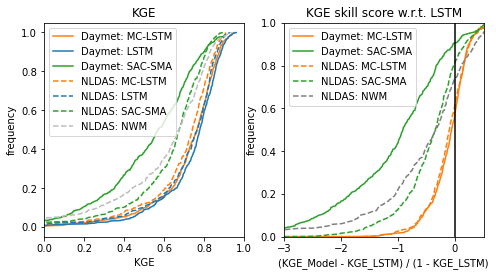

In [48]:
fig = plt.figure(figsize=cm2inch(20,10))

print("metric", "KGE")
metric_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}
for forcing_type in ['daymet','nldas']:
    print("forcing_type", forcing_type)
    _, wilcoxon_p = st.wilcoxon(st2_dict[forcing_type]["KGE"]["mc"],
                                 st2_dict[forcing_type]["KGE"]["lstm"])
    print("wilcoxon p value", np.round(wilcoxon_p,2))
    metric_dict["mc"] = st2_dict[forcing_type]["KGE"]["mc"]
    metric_dict["lstm"] = st2_dict[forcing_type]["KGE"]["lstm"]

ax = fig.add_subplot(1, 2, 1)

ax.plot(np.sort(st2_dict['daymet']["KGE"]['mc']), yvalues, label='Daymet: MC-LSTM', c=colz[1])
ax.plot(np.sort(st2_dict['daymet']["KGE"]['lstm']), yvalues, label='Daymet: LSTM', c=colz[0])
ax.plot(np.sort(st2_dict['daymet']["KGE"]['sac']), yvalues, label='Daymet: SAC-SMA', c=colz[2])
ax.plot(np.sort(st2_dict['nldas']["KGE"]['mc']), yvalues, label='NLDAS: MC-LSTM', c=colz[1], ls='--')
ax.plot(np.sort(st2_dict['nldas']["KGE"]['lstm']), yvalues, label='NLDAS: LSTM', c=colz[0], ls='--')
ax.plot(np.sort(st2_dict['nldas']["KGE"]['sac']), yvalues, label='NLDAS: SAC-SMA', c=colz[2], ls='--')
ax.plot(np.sort(st2_dict['nldas']["KGE"]['nwm']), yvalues, label='NLDAS: NWM', c=colz[3], ls='--')
ax.set_xlim([0,1])
plt.legend()
plt.title("KGE")
plt.xlabel("KGE")
plt.ylabel("frequency")


# --------------------------------------------------------------------------------------------------- #

kgess_st2_dict = {forcing_type:{} for forcing_type in ['daymet','nldas']}

for forcing_type in ['daymet','nldas']:
    kgess_st2_dict[forcing_type]['MC-LSTM'] = (np.array(st2_dict[forcing_type]["KGE"]["mc"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"])) 
for forcing_type in ['daymet','nldas']:
    kgess_st2_dict[forcing_type]['SAC-SMA'] = (np.array(st2_dict[forcing_type]["KGE"]["sac"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"]))
for forcing_type in ['nldas']:
    kgess_st2_dict[forcing_type]['NWM'] = (np.array(st2_dict[forcing_type]["KGE"]["nwm"]) - \
                                                    np.array(st2_dict[forcing_type]["KGE"]["lstm"])) / \
                                                   (1 - np.array(st2_dict[forcing_type]["KGE"]["lstm"]))
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

yvalues = list(range(len(kgess_st1_dict['daymet']['SAC-SMA'])))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)        

    
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.sort(kgess_st2_dict['daymet']['MC-LSTM']), yvalues, label='Daymet: MC-LSTM', c=colz[1])
ax.plot(np.sort(kgess_st2_dict['daymet']['SAC-SMA']), yvalues, label='Daymet: SAC-SMA', c=colz[2])
ax.plot(np.sort(kgess_st2_dict['nldas']['MC-LSTM']), yvalues, label='NLDAS: MC-LSTM', c=colz[1], ls='--')
ax.plot(np.sort(kgess_st2_dict['nldas']['SAC-SMA']), yvalues, label='NLDAS: SAC-SMA', c=colz[2], ls='--')
ax.plot(np.sort(kgess_st2_dict['nldas']['NWM']), yvalues, label='NLDAS: NWM', c='grey', ls='--')
ax.plot([0,0], [0,1], c='k')
ax.set_xlim([-3,.5])
ax.set_ylim([0,1])
plt.legend()
plt.title("KGE skill score w.r.t. LSTM")
plt.xlabel("(KGE_Model - KGE_LSTM) / (1 - KGE_LSTM)")
plt.ylabel("frequency")

plt.show()

fig.tight_layout()
fig.savefig(f'../figs/kge_skill_score_{time_splitz[1]}_ens.pdf', dpi=600)
fig.savefig(f'../figs/kge_skill_score_{time_splitz[1]}_ens.png', dpi=600)

plt.close()

time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type nldas
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split1
forcing type daymet
models ['lstm', 'mc', 'sac']


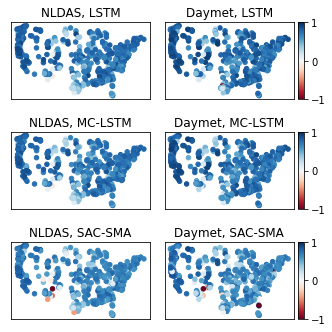

time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type nldas
models ['lstm', 'mc', 'sac', 'nwm']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']
time split time_split2
forcing type daymet
models ['lstm', 'mc', 'sac']


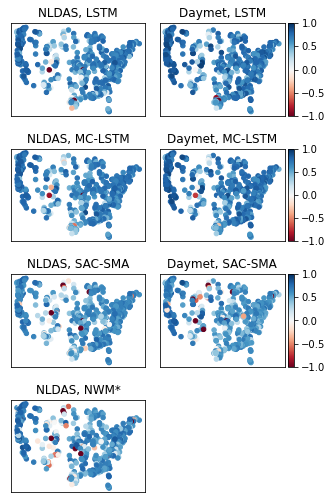

In [27]:

for tsplt in time_splitz:

    if tsplt == 'time_split1':
        fig = plt.figure(figsize=cm2inch(12,12))
        plot_dict = st1_dict
    if tsplt == 'time_split2':
        fig = plt.figure(figsize=cm2inch(12,18))
        plot_dict = st2_dict
    plot_here=1

    for forcing_type in forcing_products:

        models, flows = get_models_flows(forcing_type, tsplt)

        for model in models:
            
            print('time split', tsplt)
            print('forcing type', forcing_type)
            print('models', models)

            if forcing_type == 'daymet' and model == 'nwm':
                continue

            if forcing_type == 'nldas' and model == 'lstm':
                plot_here = 1
            if forcing_type == 'daymet' and model == 'lstm':
                plot_here = 2
            if forcing_type == 'nldas' and model == 'mc':
                plot_here = 3
            if forcing_type == 'daymet' and model == 'mc':
                plot_here = 4
            if forcing_type == 'nldas' and model == 'sac':
                plot_here = 5
            if forcing_type == 'daymet' and model == 'sac':
                plot_here = 6

            if tsplt == 'time_split2':
                if forcing_type == 'nldas' and model == 'nwm':
                    plot_here = 7
                    
            if tsplt == 'time_split2':
                ax = fig.add_subplot(4, 2, plot_here)
            if tsplt == 'time_split1':
                ax = fig.add_subplot(3, 2, plot_here)
                
            im = ax.scatter(pd_attributes.loc[basin_list_531_int, 'gauge_lon'].values, 
                             pd_attributes.loc[basin_list_531_int, 'gauge_lat'].values,
                            c=plot_dict[forcing_type]['NSE'][model],
                            s=20,
                            cmap='RdBu',
                            vmin=-1, 
                            vmax=1)
            ax.set_title(str(forcingz[forcing_type])+', '+str(labelz[model]))

    #        ax.set_xlabels([])
            ax.set_xticks(ticks=[])
            ax.set_yticks(ticks=[])

            clims = im.get_clim()


            # colorbar
            if plot_here in [2,4,6]:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im, cax=cax, orientation='vertical')

            plot_here+=1

    plt.tight_layout()
    plt.show()
    plt.close()

NSE, LSTM - MC-LSTM


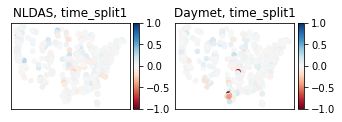

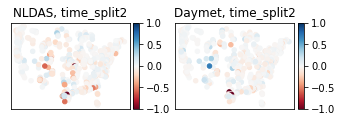

MSE, LSTM - MC-LSTM


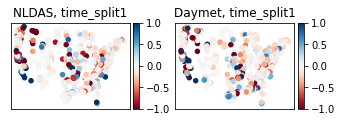

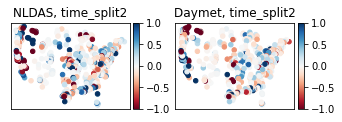

RMSE, LSTM - MC-LSTM


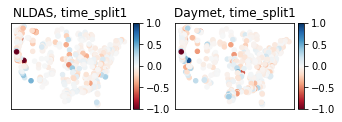

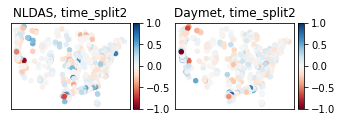

KGE, LSTM - MC-LSTM


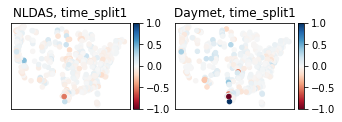

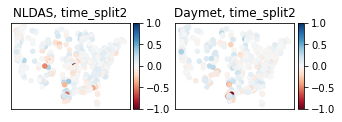

Alpha-NSE, LSTM - MC-LSTM


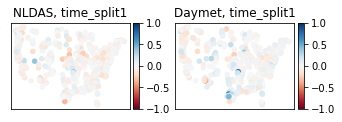

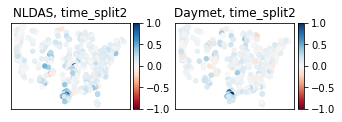

Pearson-r, LSTM - MC-LSTM


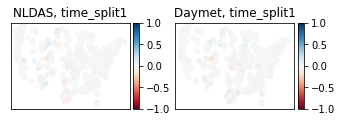

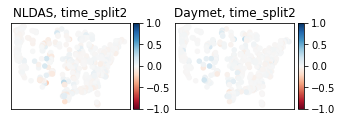

Beta-NSE, LSTM - MC-LSTM


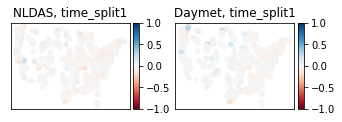

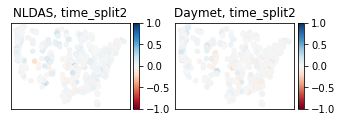

FHV, LSTM - MC-LSTM


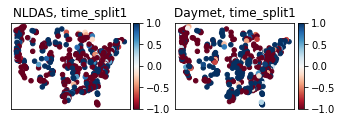

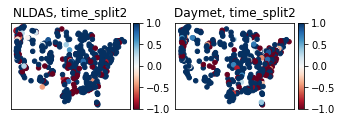

FMS, LSTM - MC-LSTM


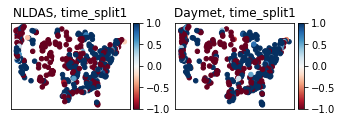

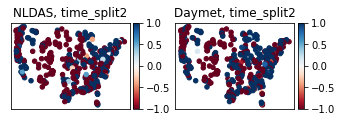

FLV, LSTM - MC-LSTM


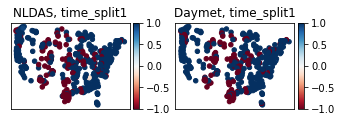

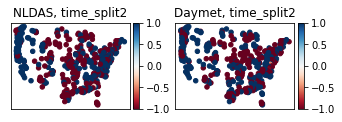

Peak-Timing, LSTM - MC-LSTM


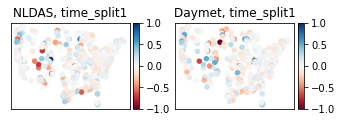

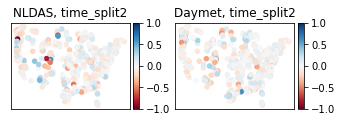

In [28]:

for metric in list(st1_dict['nldas'].keys()):
    
    print(metric+", LSTM - MC-LSTM")

    plot_here=1

    for tsplt in time_splitz:

        if tsplt == 'time_split1':
            fig = plt.figure(figsize=cm2inch(12,8))
            plot_dict = st1_dict
        if tsplt == 'time_split2':
            fig = plt.figure(figsize=cm2inch(12,8))
            plot_dict = st2_dict


        for forcing_type in forcing_products:

            plot_this = list(np.array(plot_dict[forcing_type][metric]['lstm']) - \
                             np.array(plot_dict[forcing_type][metric]['mc']))

            ax = fig.add_subplot(2, 2, plot_here)

            im = ax.scatter(pd_attributes.loc[basin_list_531_int, 'gauge_lon'].values, 
                             pd_attributes.loc[basin_list_531_int, 'gauge_lat'].values,
                            c=plot_this,
                            s=20,
                            cmap='RdBu',
                            vmin=-1, 
                            vmax=1)
            ax.set_title(str(forcingz[forcing_type])+', '+tsplt)

    #        ax.set_xlabels([])
            ax.set_xticks(ticks=[])
            ax.set_yticks(ticks=[])

            clims = im.get_clim()


            # colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')

            plot_here+=1
        plt.tight_layout()
        plt.show()
        plt.close()

In [29]:
list(st1_dict['nldas'].keys())

['NSE',
 'MSE',
 'RMSE',
 'KGE',
 'Alpha-NSE',
 'Pearson-r',
 'Beta-NSE',
 'FHV',
 'FMS',
 'FLV',
 'Peak-Timing']